# Punch classification

# Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

2024-10-14 07:34:07.877275: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 07:34:07.877768: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 07:34:07.880088: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 07:34:07.886139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 07:34:07.896746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

### Test GPU support

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


I0000 00:00:1728884049.068762 1425242 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-14 07:34:09.069230: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Data preparation

### Download data

In [3]:
!rm -rf data/annotated_images
!gdown 1PYvUwNru0N4iqG-CzQcv5ORMd3Mo96Pl -O data/annotated_images.zip
!gdown 1CwGTWuMlWeOoiqzQ39B3snRRquoaX5cA -O data/annotations_map.json
!unzip -q data/annotated_images.zip -d data

Downloading...
From (original): https://drive.google.com/uc?id=1PYvUwNru0N4iqG-CzQcv5ORMd3Mo96Pl
From (redirected): https://drive.google.com/uc?id=1PYvUwNru0N4iqG-CzQcv5ORMd3Mo96Pl&confirm=t&uuid=0e7fb4ec-9d95-466f-810b-2d2de7abf720
To: /home/piotr/PycharmProjects/boxing-fight-video-analysis/data/annotated_images.zip
100%|██████████████████████████████████████| 50.1M/50.1M [00:06<00:00, 7.77MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CwGTWuMlWeOoiqzQ39B3snRRquoaX5cA
To: /home/piotr/PycharmProjects/boxing-fight-video-analysis/data/annotations_map.json
100%|██████████████████████████████████████████| 233/233 [00:00<00:00, 2.13MB/s]


### Restructure the data

In [4]:
# get only 3 punch classes, without information from which hand the punch came from
!mv data/annotated_images/2/* data/annotated_images/1/
!mv data/annotated_images/4/* data/annotated_images/3/
!mv data/annotated_images/6/* data/annotated_images/5/

!rmdir data/annotated_images/2
!rmdir data/annotated_images/4
!rmdir data/annotated_images/6

# removing examples with misses
!rm -rf data/annotated_images/7
!rm -rf data/annotated_images/8

Check number of examples between classes

Class `1` contain examples with punches to the *head*

Class `3` contain examples with punches to the *corpus*

Class `5` contain examples with punches to the *block*

In [5]:
!ls data/annotated_images/1 | wc -l
!ls data/annotated_images/3 | wc -l
!ls data/annotated_images/5 | wc -l

3575
458
1082


### Create dataset

In [6]:
import pathlib

data_dir = pathlib.Path('data/annotated_images')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Dataset contains {image_count} examples')

Dataset contains 5115 examples


In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5115 files belonging to 3 classes.
Using 4092 files for training.


I0000 00:00:1728884066.899331 1425242 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-14 07:34:26.899434: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5115 files belonging to 3 classes.
Using 1023 files for validation.


### Visualize the data

2024-10-14 07:34:27.136321: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


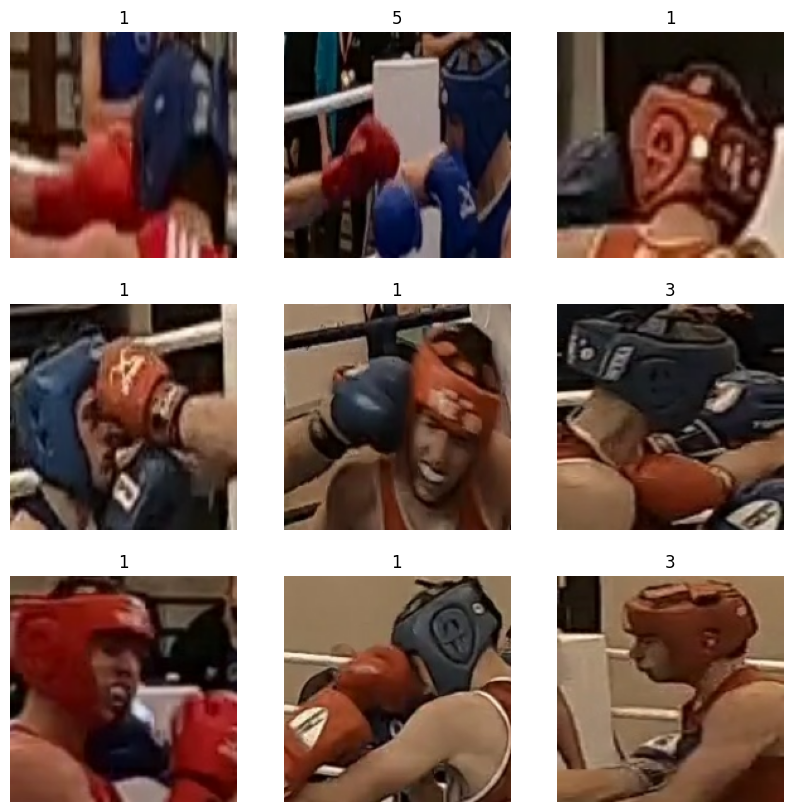

In [10]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

Configure dataset to the performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training

### Create the model

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


/home/piotr/PycharmProjects/boxing-fight-video-analysis/venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model compile and summary

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.6425 - loss: 0.9449 - val_accuracy: 0.6921 - val_loss: 0.7185
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7377 - loss: 0.6325 - val_accuracy: 0.7595 - val_loss: 0.5778
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8156 - loss: 0.4626 - val_accuracy: 0.7703 - val_loss: 0.5692
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8768 - loss: 0.3296 - val_accuracy: 0.7898 - val_loss: 0.5136
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9111 - loss: 0.2373 - val_accuracy: 0.7937 - val_loss: 0.5664
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9639 - loss: 0.1083 - val_accuracy: 0.7986 - val_loss: 0.6738
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9715 - loss: 0.0799 - val_accuracy: 0.7928 - val_loss: 0.9037
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9901 - loss: 0.0391 - 

# Model evaluation
### Calculate metrics

In [15]:
def evaluate_model(val_ds, model):
    y_pred = []
    y_true = []

    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred = y_pred + np.argmax(tf.nn.softmax(predictions), axis=1).tolist()
        y_true = y_true + batch_labels.numpy().tolist()
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

In [16]:
evaluate_model(val_ds, model)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       698
           1       0.86      0.68      0.76        96
           2       0.64      0.59      0.62       229

    accuracy                           0.81      1023
   macro avg       0.78      0.72      0.75      1023
weighted avg       0.81      0.81      0.81      1023

[[629   6  63]
 [ 17  65  14]
 [ 88   5 136]]


2024-10-14 07:37:53.643671: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Visualize training history

In [17]:
def visualize_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    f = plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    #f.savefig("training-history.pdf", bbox_inches='tight')

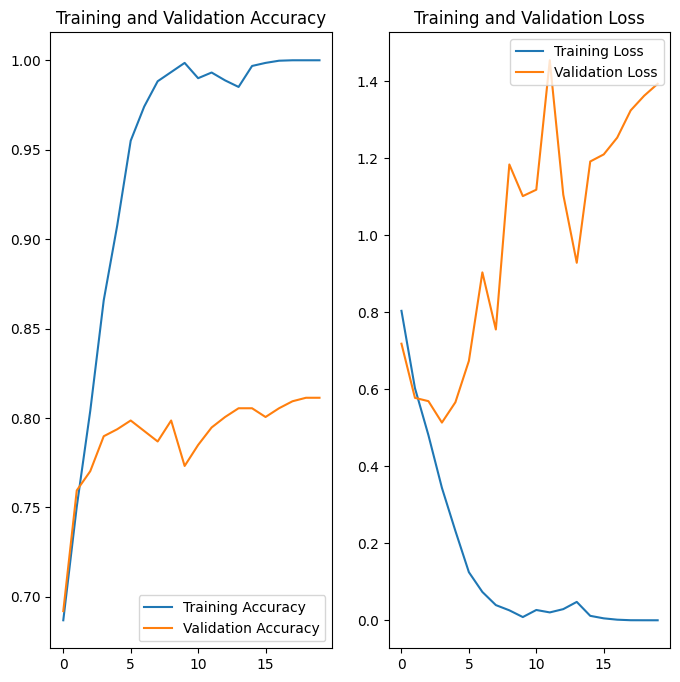

In [18]:
visualize_training_history(history)

# Prevent overfitting - add data augmentation stage and dropout

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
    #layers.RandomBrightness(0.15)
  ]
)

/home/piotr/PycharmProjects/boxing-fight-video-analysis/venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Visualize data augmentation effect

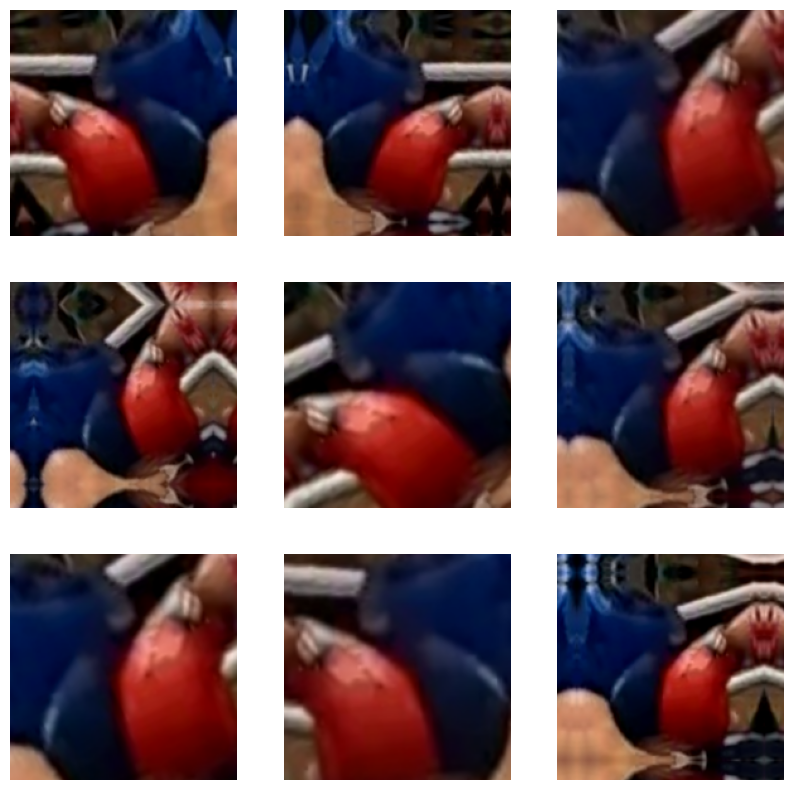

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):

    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

# Training
### Create the model

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Model compile and summary

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [23]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.7063 - loss: 0.8156 - val_accuracy: 0.6823 - val_loss: 0.7434
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.7096 - loss: 0.7060 - val_accuracy: 0.7214 - val_loss: 0.6272
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.7320 - loss: 0.6497 - val_accuracy: 0.7331 - val_loss: 0.6033
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.7527 - loss: 0.6180 - val_accuracy: 0.7498 - val_loss: 0.6050
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.7528 - loss: 0.6036 - val_accuracy: 0.7468 - val_loss: 0.5806
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.7402 - loss: 0.6088 - val_accuracy: 0.7439 - val_loss: 0.5664
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.7516 - loss: 0.5916 - val_accuracy: 0.7761 - val_loss: 0.5481
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.7598 - loss: 0.5826 - 

# Model evaluation
### Calculate metrics

In [24]:
evaluate_model(val_ds, model)

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       698
           1       0.59      0.90      0.71        96
           2       0.77      0.39      0.52       229

    accuracy                           0.80      1023
   macro avg       0.73      0.73      0.70      1023
weighted avg       0.80      0.80      0.78      1023

[[639  33  26]
 [  9  86   1]
 [111  28  90]]


2024-10-14 07:42:08.696842: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Visualize training history

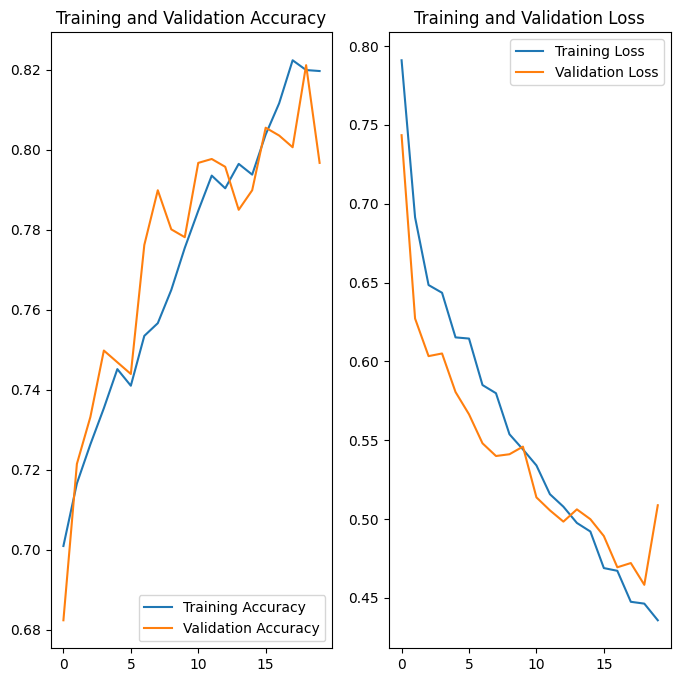

In [25]:
visualize_training_history(history)